# Check lfp traces

**In brief**:

* 854 neurons
* 0.07% of `S1FL` region
* Layers 3 to 6
* Are all the cells from the 30K cells microcircuit, the `hex0` group?


**Questions**: 

* why do the spike waveforms look so poor?
    * background noise produced by neighboring cells and recorded by the probe's contact likely distorts the true spike waveform. Can we plot the raw spike waveform extracted from the change in membrane potential simulated by NEURON?
* what criterion is used to decide when a spike is timestamped? 
* a spike is recorded by multiple nearby channels? What criterion is used to decide from which channel one should extract the "final" waveform?
    * likely the closest channel, where the spike amplitude should be maxinmal
* the simulation produces 30 trace and spike files ("pieces") that contain activity for 851 neurons. How were these neurons chosen?
* How well can we estimate the ground truth neurons known locations from their spike train and the recorded traces with the "center of mass" method?

**Notes**:

* Even one 4 sec piece of simulation is too large to be loaded at runtime in memory with report.get() on a compute node in interactive mode (with --mem=0). The associated lfp.h5 is 1.2TB.

# Setup

env_silico

In [1]:
# SETUP PACKAGES
%load_ext autoreload
%autoreload 2
import os
import pprint as pp
import pandas as pd
import yaml
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as spost
from probeinterface.plotting import plot_probe
from spikeinterface.comparison import GroundTruthStudy
import shutil
from datetime import datetime

pd.set_option('display.max_colwidth', None)

# SET PATHS
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"

os.chdir(PROJ_PATH)
from src.nodes.io.silico.loading import load_campaign_params
from src.nodes.truth.silico import ground_truth
from src.nodes.io.silico import loading_raw_recording
from src.nodes.prepro import preprocess
from src.nodes.utils import get_config, write_metadata
from src.nodes.postpro import waveform

# SET PARAMETERS
EXPERIMENT = "supp/silico_reyes"    # specifies the experiment 
SIMULATION_DATE = "2023_01_13" # specifies the run (date)

# select channels
CHANNEL_IDS = np.arange(0,128).tolist()   # plot traces from channels nearest to filtered neuron group


# SETUP CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET CONFIG PATHS
# STUDY_FOLDER = data_conf["sorting"]["simulation"]["study"]["output"]


# set output figure paths
FIG_PATH = data_conf["figures"]["silico"]["lfp_traces"]

2023-03-17 09:58:48,514 - root - utils.py - get_config - INFO - Reading experiment config.
2023-03-17 09:58:48,532 - root - utils.py - get_config - INFO - Reading experiment config. - done


# Check raw lfp traces

Describe data

In [2]:
# load the raw lfp recording (slow)
trace = loading_raw_recording.load(data_conf)

In [3]:
# inspect object
print(f"\ntrace type: \n {type(trace)}\n")
print(f"trace attributes: \n")
print(dir(trace))

# inspect the raw lfp recording
duration = trace.get_total_duration()
print(f"trace recording duration: {duration} secs\n")
print(f"channel (count)\n: {trace.get_num_channels()} channels\n")
print("channel 2D locations:\n")
print(trace.get_channel_locations())


trace type: 
 <class 'spikeinterface.core.binaryfolder.BinaryFolderRecording'>

trace attributes: 

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annotations', '_bin_kwargs', '_channel_slice', '_check_segment_index', '_dtype', '_extra_metadata_from_folder', '_extra_metadata_to_folder', '_features', '_frame_slice', '_get_file_path', '_kwargs', '_main_annotations', '_main_features', '_main_ids', '_main_properties', '_preferred_mp_context', '_properties', '_recording_segments', '_remove_channels', '_sampling_frequency', '_save', '_select_segments', 'add_recording_segment', 'annotate', 'binary_compatible_with', 'channel_ids', 'channel_slice', 'check_if_dumpable', 'clear_channel_groups', 'clear

Check realism

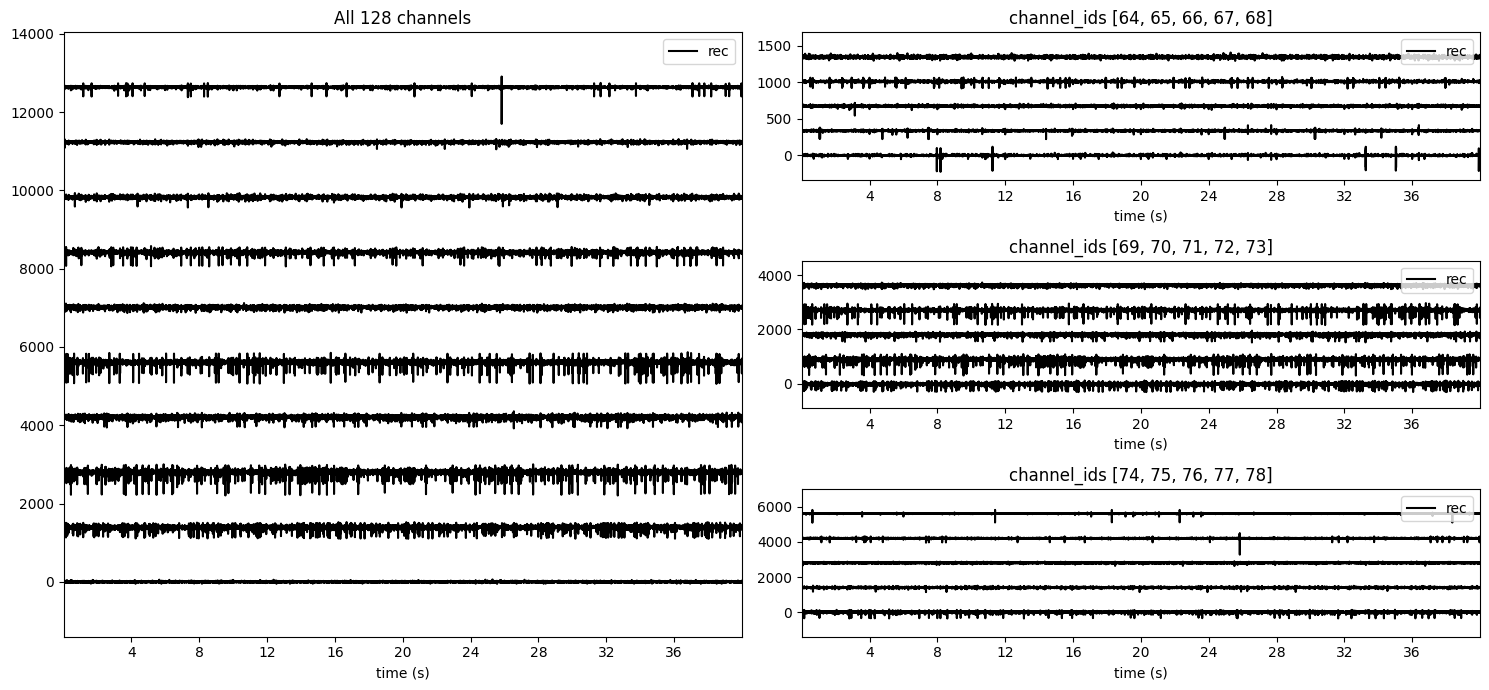

In [6]:
# Show example of the traces recorded from the five first channels
fig = plt.figure(figsize=(15, 7))
spec = fig.add_gridspec(3, 2)

CHANNEL_IDS = np.arange(68, 78, 1)

ax1 = fig.add_subplot(spec[:, 0])
sw.plot_timeseries(trace, channel_ids=CHANNEL_IDS, time_range=(0, duration), ax=ax1)
ax1.set_title("All 128 channels")
ax1.set_xlabel("time (s)")

ax2 = fig.add_subplot(spec[0, 1])
channel_ids = [64, 65, 66, 67, 68]
sw.plot_timeseries(trace, channel_ids=channel_ids, time_range=(0, duration), ax=ax2)
ax2.set_title(f"channel_ids {channel_ids}")

ax3 = fig.add_subplot(spec[1, 1])
channel_ids = [69, 70, 71, 72, 73]
sw.plot_timeseries(trace, channel_ids=channel_ids, time_range=(0, duration), ax=ax3)
ax3.set_title(f"channel_ids {channel_ids}")

ax4 = fig.add_subplot(spec[2, 1])
channel_ids = [74, 75, 76, 77, 78]
sw.plot_timeseries(trace, channel_ids=channel_ids, time_range=(0, duration), ax=ax4)
ax4.set_title(f"channel_ids {channel_ids}")
plt.tight_layout()

We can compare it at scale to `Hagen et al., (2015), Journal of Neuroscience Methods` traces in the mouse's visual cortex.


<>:10: DeprecationWarning: invalid escape sequence \m
<>:10: DeprecationWarning: invalid escape sequence \m
/tmp/ipykernel_184533/836454720.py:10: DeprecationWarning: invalid escape sequence \m
  ax3.set_ylabel("Amplitude ($\mu V$)", fontsize=16);


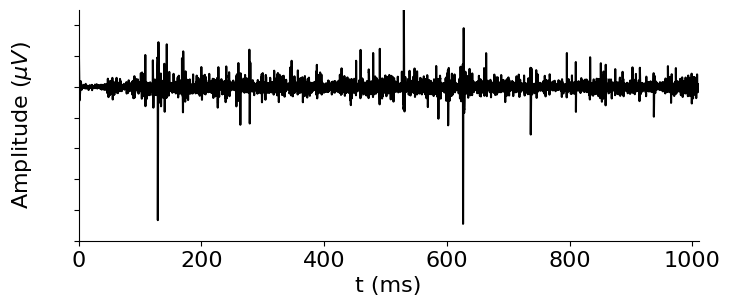

In [36]:
# Show example of the traces recorded from the five first channels
fig = plt.figure(figsize=(8, 3))
DURATION = 1.01

ax3 = fig.add_subplot(1, 1, 1)
CHANNEL_IDS = [50]
sw.plot_timeseries(trace, channel_ids=CHANNEL_IDS, time_range=(0, DURATION), ax=ax3)
# ax3.set_title(f"channel_ids {channel_ids}");
ax3.set_xlabel("t (ms)", fontsize=16)
ax3.set_ylabel("Amplitude ($\mu V$)", fontsize=16)
ax3.set_xticks(np.arange(0, DURATION, 0.2))
ax3.set_xticklabels(np.arange(0, DURATION * 1000, 200).astype(int), fontsize=16)
plt.yticks(color="w")
ax3.spines[["right", "top"]].set_visible(False)
ax3.set_ylim([-50, 25])
ax3.get_legend().remove()

In [7]:
# save figure
fig.savefig(FIG_PATH + ".png")

# write metadata
metadata = {
    "fig_path": FIG_PATH,
    "creation_date": datetime.now().strftime("%d/%m/%Y %H:%M:%S"),
    "simulation_date": SIMULATION_DATE,
    "data_conf": data_conf,
    "param_conf": param_conf,
}
write_metadata(metadata, FIG_PATH)

# References

(1) https://probeinterface.readthedocs.io/en/stable/examples/ex_05_device_channel_indices.html 

(2) https://spikeinterface.readthedocs.io/en/latest/modules/core/plot_4_waveform_extractor.html 